In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Preprocessing of the dataset

In [76]:
#split dataset
path = "/Users/giovanna/Desktop/Magistrale/SecondoAnno/AIBioInfo/Labs/LAB2_BNN/dataset_LUMINAL_A_B.csv"
test_df = pd.read_csv(path)

first way to encode the labels

In [77]:
test_df['l'] = test_df['l'].str.replace(r'\s+', '', regex=True)
label_mapping = {
    'LuminalB': 1.0,
    'LuminalA': 0.0,
}

test_df['l'] = test_df['l'].map(label_mapping)
test_df = test_df.sample(frac=1).reset_index(drop=True)

Extract X and y from the dataset

In [78]:
y = test_df['l']
X = test_df.drop('l', axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)


Now split the dataset and scale train and test

In [79]:
# now split dataset into train and test
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

Performing dimensionality reduction as the features are a lot and it's unfeaseable to train a model on such a huge dataset

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=80)
X_train_pca = pca.fit_transform(X_train).astype(np.float32)
X_test_pca = pca.transform(X_test).astype(np.float32)   

transforming data from numpy to tensors

In [81]:
X_train_t = torch.from_numpy(X_train_pca)
X_test_t = torch.from_numpy(X_test_pca)
y_train_t = torch.from_numpy(y_train.values)
y_test_t = torch.from_numpy(y_test.values)

## Dataloader

In [82]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
batchsize = 8
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

## Model

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = X_train_t.shape[1]
hidden1 = 200
hidden2 = 75
output = 1

class BNN(nn.Module):
    def __init__(self):
        super(BNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden2, output),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.model(X)

model = BNN()
print(model)

BNN(
  (model): Sequential(
    (0): Linear(in_features=80, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=200, out_features=75, bias=True)
    (5): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=75, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [89]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [90]:
def eval_acc(mlp: nn.Module, data_loader: torch.utils.data.DataLoader):
  
  correct = 0
  total = 0
  
  with torch.no_grad():
    for x, y in data_loader:
      y_pred = model(x)
      # print(y_pred)
      y_pred_discr = torch.round(y_pred)
      # print(y_pred_discr)
      # print(y_pred.shape, y_pred_discr.shape, y.shape)
      acc = torch.sum((y_pred_discr == y).float()) 
      correct += acc
      total += y_pred.size(0)
  
  return correct/total

Now starts the actual training of the network

In [91]:
model.train()
train_loss = []

try:
    for epoch in range(epochs):
        print(f"Epoch {epoch} train accuracy: {eval_acc(model, train_dataloader)} "
                f"test accuracy: {eval_acc(model, test_dataloader)}")

        #Within each epoch run the subsets of data = batch sizes.
        for x_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            y_pred = y_pred.view(-1)
            y_pred = y_pred.float()
            y_batch = y_batch.float()
            # print("dim output nel train", y_pred.shape, y_batch.shape)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, loss.item()))
except KeyboardInterrupt:
    pass

Epoch 0 train accuracy: 3.799999952316284 test accuracy: 3.700000047683716
Epoch: 1 	Training Loss: 0.704822
Epoch 1 train accuracy: 4.099999904632568 test accuracy: 3.700000047683716
Epoch: 2 	Training Loss: 0.609487
Epoch 2 train accuracy: 4.150000095367432 test accuracy: 3.5999999046325684
Epoch: 3 	Training Loss: 0.485352
Epoch 3 train accuracy: 3.875 test accuracy: 3.5999999046325684
Epoch: 4 	Training Loss: 0.483693
Epoch 4 train accuracy: 4.224999904632568 test accuracy: 3.700000047683716
Epoch: 5 	Training Loss: 0.442454
Epoch 5 train accuracy: 4.300000190734863 test accuracy: 3.700000047683716
Epoch: 6 	Training Loss: 0.259077
Epoch 6 train accuracy: 4.150000095367432 test accuracy: 3.5999999046325684
Epoch: 7 	Training Loss: 0.338176
Epoch 7 train accuracy: 4.199999809265137 test accuracy: 3.5
Epoch: 8 	Training Loss: 0.274356
Epoch 8 train accuracy: 4.349999904632568 test accuracy: 3.5999999046325684
Epoch: 9 	Training Loss: 0.161795
Epoch 9 train accuracy: 4.300000190734863

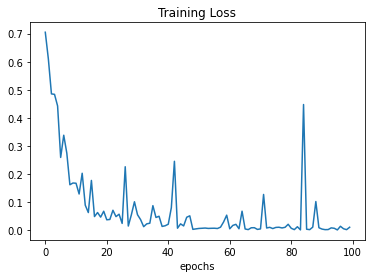

In [92]:
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("epochs")
plt.show()